In [1]:
%matplotlib inline
#import os
import pandas as pd
import numpy as np
from sklearn.cross_validation import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from src.refined_rf import RefinedRandomForest
from src.telstra_data import TelstraData, multiclass_log_loss
from matplotlib import pyplot as plt

# Global refinement of random forest

The approach described in the paper "[Global Refinement of Random Forest](http://www.cv-foundation.org/openaccess/content_cvpr_2015/papers/Ren_Global_Refinement_of_2015_CVPR_paper.pdf)" is claimed to improve random forest performance while simultaneously reducing model size. I decided to give it a try on the Telstra competion's problem. 

The idea is to build a random forest, then fit a regularized linear model using all leaves as binary features (leaf1\_tree1, leaf2\_tree1...,leafM-1\_treeN, leafM_treeN). Then a small proportion (10%) of least significant leaves is pruned, and the linear model is rerun on the new set of leaves. This process is repeated until a desired model size or a desired performance metric is reached.

The code for refinement is in [`src/refined_rf.py`](https://github.com/gereleth/kaggle-telstra/blob/master/src/refined_rf.py). For solving the logistic regression I use `sklearn.linear_model.LogisticRegression` with solver `lbfgs` that can handle multinomial loss with L2 regularisation.

Refined RF and ET models accounted for 35% of my final ensemble. They had cv scores in the range 0.440-0.445, compared to 0.460 with a regular random forest having the same number of trees.

Below I'll show an example of how the refinement works.

## Load data

Load the data and split it into train and test portions.

In [2]:
featureparams = {'location_min_count': 0,
 'n_common_events': 20,
 'n_common_log_features': 40,
 'n_common_resources': 5,
 'n_label_encoded_log_features': 4}
aggregateparams = {"loc_agg_prior_weight":3.0}

In [3]:
data = TelstraData(**featureparams)
y = data.get_y()
kf = StratifiedKFold(y.values, n_folds=10, shuffle=True, random_state = 1234)
for itrain, itest in kf:
    Xtr, ytr, Xte, yte = data.get_train_test_features(itrain, itest, **aggregateparams)
    break

## Regular random forest

Let's try predicting fault severities with a random forest:

In [4]:
clf = RandomForestClassifier(n_estimators=200, min_samples_leaf=5, max_features=20, random_state=1)
clf.fit(Xtr, ytr)
loss2tr = multiclass_log_loss(ytr.values, clf.predict_proba(Xtr))
loss2te = multiclass_log_loss(yte.values, clf.predict_proba(Xte))
print("Random Forest: train loss {:.4f}, test loss {:.4f}".format(loss2tr, loss2te))

Random Forest: train loss 0.2735, test loss 0.4477


## Refined random forest

Now let's try the same with a refined random forest. We create a refined random forest object and fit to the same training data. 

This will use forest's leaves as binary features and fit a logistic regression to them. For now we don't prune any leaves.

In [5]:
rrf = RefinedRandomForest(clf, C = 0.01, n_prunings = 0)
rrf.fit(Xtr, ytr)
loss3tr = multiclass_log_loss(ytr.values, rrf.predict_proba(Xtr))
loss3te = multiclass_log_loss(yte.values, rrf.predict_proba(Xte))
print("Refined Random Forest, not pruned: train loss {:.4f}, test loss {:.4f}".format(loss3tr, loss3te))

Refined Random Forest, not pruned: train loss 0.1341, test loss 0.4698


Looks like we get a decrease of training error and an increase of test set error, which means the model started overfitting. The global pruning of forest helps combat this. I'll start an iterative pruning of the forest cutting away 10% of leaves at every iteration and record train set loss, test set loss and number of leaves.

In [6]:
rrf.n_prunings = 1 # do one pruning in each iteration
trainloss = [loss3tr]
testloss = [loss3te]
nleaves = [sum(rrf.n_leaves_)] # remember number of leaves in each iteration
for k in range(100):
    rrf.fit(Xtr, ytr) # fit and do 1 pruning
    loss4tr = multiclass_log_loss(ytr.values, rrf.predict_proba(Xtr))
    loss4te = multiclass_log_loss(yte.values, rrf.predict_proba(Xte))
    trainloss.append(loss4tr)
    testloss.append(loss4te)
    nleaves.append(sum(rrf.n_leaves_))
    #print("Pruning {:02d}: train loss {:.4f}, test loss {:.4f}".format(k+1, loss4tr, loss4te))
    if loss4te > 0.48:
        break # stop when test error increases too much

Let's see the results on a plot:

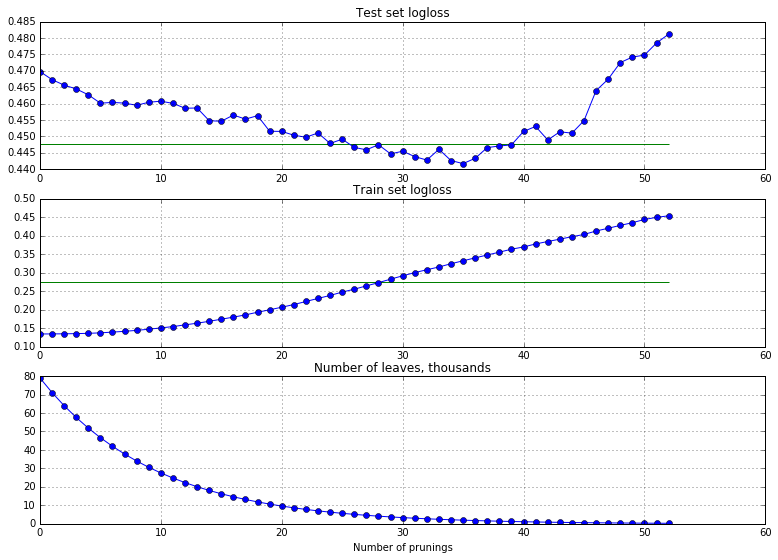

In [7]:
nprunings = np.arange(len(trainloss))
fig, ax = plt.subplots(3, figsize=(13,9))
ax[0].plot(nprunings, testloss, '-o')
ax[0].set_title('Test set logloss')
ax[0].grid()
ax[0].hlines(loss2te, nprunings.min(), nprunings.max(), colors='g', linestyles='solid')
ax[1].plot(nprunings, trainloss, '-o')
ax[1].set_title('Train set logloss')
ax[1].grid()
ax[1].hlines(loss2tr, nprunings.min(), nprunings.max(), colors='g', linestyles='solid')
ax[2].plot(nprunings, np.array(nleaves)/1000, '-o')
ax[2].set_title('Number of leaves, thousands')
ax[2].set_xlabel('Number of prunings')
ax[2].grid()

We can see that the refined model achieved the best test set performance after 35 prunings and it was a little better than the result from the original random forest (shown as the horizontal line). At 37-39 prunings test set results were the same as the original forest. After that further prunings bring the model into underfitting regime with both train and test loss rising.

What was the number of leaves at the start and at the optimal pruning iteration?

In [8]:
nleaves[0]

78990

In [9]:
nleaves[35]

1964

Looks like it went down 40 times from 80000 to 2000. So we can say that this method achieves remarkable model compression at least.

This optimal number of prunings varies depending on our train/validation split and random seed of the original forest, so I couldn't find some fixed value that would be best for generating test submissions. Instead in each fold I would run the refinement procedure on the training data while watching performance on the out-of-fold samples. Then with the best model I would predict probabilities for the test set. In the end of cross-validation loop I averaged test predictions from ten folds and took that as the model's test predictions. The number of prunings was usually in the range 6 - 20. The code that does this can be found in [`src/experiments/RRFItPrexp.py`](https://github.com/gereleth/kaggle-telstra/blob/master/src/experiments/RRFItPrexp.py).

## Better settings for "refinability"

*What follows are thoughts that did not occur to me during the competition, I only thought about this as I was preparing this notebook.*

Since we're pruning a lot of leaves anyway we might want to limit tree depth of the original forest. We may also decrease `max_features` to have more diversity across trees. And since the trees are smaller, let's make more of them!

In [8]:
clf = RandomForestClassifier(n_estimators=300, max_depth=7, max_features=5, random_state=1)
clf.fit(Xtr, ytr)
loss5tr = multiclass_log_loss(ytr.values, clf.predict_proba(Xtr))
loss5te = multiclass_log_loss(yte.values, clf.predict_proba(Xte))
print("Random Forest: train loss {:.4f}, test loss {:.4f}".format(loss5tr, loss5te))

Random Forest: train loss 0.4946, test loss 0.5322


Original random forest now has much worse score than before, but can we refine it?

In [9]:
rrf = RefinedRandomForest(clf, C = 0.01, n_prunings = 0)
rrf.fit(Xtr, ytr)
loss3tr = multiclass_log_loss(ytr.values, rrf.predict_proba(Xtr))
loss3te = multiclass_log_loss(yte.values, rrf.predict_proba(Xte))
print("Refined Random Forest, not pruned: train loss {:.4f}, test loss {:.4f}".format(loss3tr, loss3te))

Refined Random Forest, not pruned: train loss 0.2178, test loss 0.4306


With a diverse set of small trees even without any prunings we get a much better score than with our original reasonably well-tuned model.

Let's see what we get after the pruning cycle.

In [10]:
rrf.n_prunings = 1 # do one pruning in each iteration
trainloss = [loss3tr]
testloss = [loss3te]
nleaves = [sum(rrf.n_leaves_)] # remember number of leaves in each iteration
for k in range(100):
    rrf.fit(Xtr, ytr) # fit and do 1 pruning
    loss4tr = multiclass_log_loss(ytr.values, rrf.predict_proba(Xtr))
    loss4te = multiclass_log_loss(yte.values, rrf.predict_proba(Xte))
    trainloss.append(loss4tr)
    testloss.append(loss4te)
    nleaves.append(sum(rrf.n_leaves_))
    #print("Pruning {:02d}: train loss {:.4f}, test loss {:.4f}".format(k+1, loss4tr, loss4te))
    if loss4te > 0.48:
        break # stop when test error increases too much

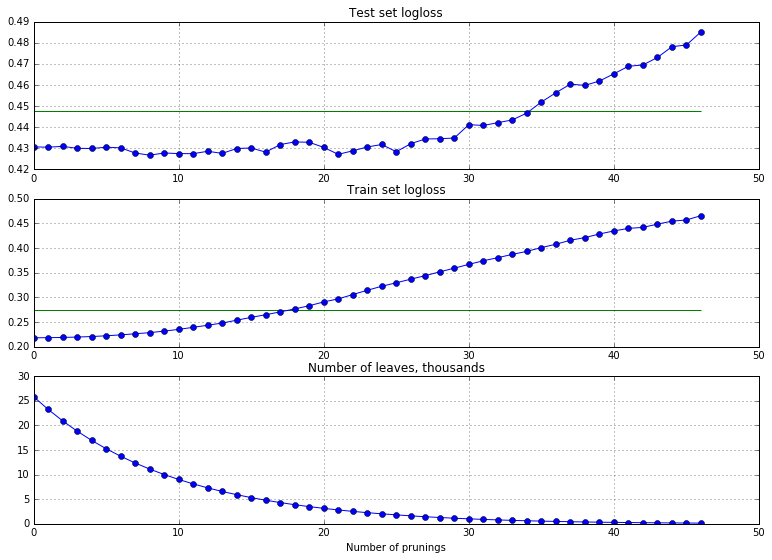

In [15]:
nprunings = np.arange(len(trainloss))
fig, ax = plt.subplots(3, figsize=(13,9))
ax[0].plot(nprunings, testloss, '-o')
ax[0].set_title('Test set logloss')
ax[0].grid()
ax[0].hlines(loss2te, nprunings.min(), nprunings.max(), colors='g', linestyles='solid')
ax[1].plot(nprunings, trainloss, '-o')
ax[1].set_title('Train set logloss')
ax[1].grid()
ax[1].hlines(loss2tr, nprunings.min(), nprunings.max(), colors='g', linestyles='solid')
ax[2].plot(nprunings, np.array(nleaves)/1000, '-o')
ax[2].set_title('Number of leaves, thousands')
ax[2].set_xlabel('Number of prunings')
ax[2].grid()

Note: this time the horizontal lines represent the well-tuned random forest results, rather than the one used for refinement.

Here we can see how test set loss stays roughly the same for about 25 pruning iterations. This probably corresponds to removing useless trees from the forest. Useless trees might be those that made some unlucky splits or just bring redundant information already contained in other trees. Then the test error starts increasing because we have to cut away useful leaves.

In [12]:
nleaves[25]

1814

In [13]:
len(rrf.trees_)

30

By the end of the process above only 30 trees survived of the original 300. At pruning 25 there were probably more, but still way less than the initial 300.

This is like we performed feature engineering when creating the original random forest and then feature selection when pruning it. What's left is a model that's remarkably good for its size.


### Full CV experiment at better settings

It looks like pruning the trees in a shallow forest affects mainly model size but doesn't improve performance any more. So I'll try to run a full 10-fold CV not doing any prunings to get an idea of what score we might get with this approach.

In [14]:
data = TelstraData(**featureparams)
y = data.get_y()
kf = StratifiedKFold(y.values, n_folds=10, shuffle=True, random_state = 1234)
pred_cols = ['predict_{}'.format(i) for i in range(3)]
pred = pd.DataFrame(0., index = y.index, columns = pred_cols)
for itrain, itest in kf:
    Xtr, ytr, Xte, yte = data.get_train_test_features(itrain, itest, **aggregateparams)
    clf = RandomForestClassifier(n_estimators=300, max_depth=7, max_features=5, random_state=1)
    clf.fit(Xtr, ytr)
    rrf = RefinedRandomForest(clf, C = 0.01, n_prunings = 0)
    rrf.fit(Xtr, ytr)
    pred.iloc[itest, :] = rrf.predict_proba(Xte)
loss = multiclass_log_loss(y.values, pred.values)
print(loss)

0.444082302749


Logloss 0.4441 is similar to some of the RRF models I used for my final ensemble. But this is also much faster because no prunings are involved, so it's possible to experiment with different settings and maybe improve the score even further.

## Final notes

- The process of refinement can improve random forest performance and remarkably reduce model size.
- A random forest that is well-tuned by itself is probably not so well suited for refinement.
- To achieve better "refinability" it might be useful to 
    - decrease max_depth of trees (we'll prune them a lot anyway)
    - decrease max_features considered at each split (to increase diversity)
    - increase number of trees (since they became smaller we can make more)
- A forest of diverse rather shallow trees may see its performance improve after refinement even without pruning the leaves.
- Refinement can be applied to ExtraTrees models just like to RandomForest models.
- For problems evaluated on probability estimates refinement can have the additional bonus of improving the model's calibration.
